In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from mord import LogisticAT
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [29]:
data = pd.read_pickle('data_clean_text.p')

In [30]:
#remove features which agents cannot change, separate target from features
X = data.drop(['bathrooms', 'latitude', 'longitude', 'building_id', 'created', 'street_address', 'description', 'display_address', 'features', 'listing_id', 'manager_id', 'photos', 'interest_level', 'neighborhood'],axis=1)
Y = data['interest_level'].copy()

#replace strings with numeric for use in models (though still assumed to be ordinal later)
Y = Y.replace(['low', 'medium', 'high'], [1,2,3])

#normalize feature values
for column in X.columns.values:
    if column == 'cleantext':
        next
    else:
        if np.max(X[column])==0:
            next
        else:
            X[column] = X[column]/np.max(X[column])

#split data into training and test sets
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8)


In [36]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """Switch for selecting text or non text features"""
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        if self.key=='text':
            return data['cleantext']
        else:
            return data.drop('cleantext',axis=1)


class VectorChooser(BaseEstimator, TransformerMixin):
    """Switch for choosing between vectorizers"""
    def __init__(self, vtype='tfidf',binary=False,ngram_range=(1,1)):
        self.vtype = vtype
        self.tfidf = TfidfVectorizer(binary,ngram_range,stop_words='english')
        self.count_vector = CountVectorizer(binary,ngram_range,stop_words='english')

    def fit(self, x, y=None):
        if self.vtype=='tfidf':
            return self.tfidf.fit(x)
        else:
            return self.count_vector.fit(x)

    def transform(self, data):
        if self.vtype=='tfidf':
            return self.tfidf.transform(data)
        else:
            return self.count_vector.transform(data)

In [16]:
#prevent warning dialogues from displaying
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Logistic Regression
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text field
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('vectorizer', VectorChooser(binary = True)),
            ])),

            # Pipeline for K best selection of non-text features
            ('alt_features', Pipeline([
                ('selector', ItemSelector(key='features')),
                ('kbest', SelectKBest())
            ]))

        ]
    )),

    ('logistic', LogisticRegression())
])
#paramters to search on, 
#key is nested:
###'union' vs 'modelname'  then __
###then feature type 'text' vs 'alt_features'
###then modelname to adjust paramters
###then parameter for which you are adjusting values
#value is the values for the parameter through which to cycle gridsearch
parameters = {
    'logistic__solver': ['lbfgs'],
    'union__text__vectorizer__ngram_range': ((1,1),(1,2),(2,2)),
    'union__text__vectorizer__binary': (True, False),
    'logistic__C': np.power(10.0, np.arange(-3,3))
}

#Grid search across one model
grid_search = GridSearchCV(pipeline, parameters, verbose=1,scoring = 'mean_absolute_error')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
grid_search.fit(X_train, Y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['union', 'logistic']
parameters:
{'logistic__C': array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02]),
 'logistic__solver': ['lbfgs'],
 'union__text__vectorizer__binary': (True, False),
 'union__text__vectorizer__ngram_range': ((1, 1), (1, 2), (2, 2))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 15.5min finished


Best score: -0.357
Best parameters set:
	logistic__C: 10.0
	logistic__solver: 'lbfgs'
	union__text__vectorizer__binary: True
	union__text__vectorizer__ngram_range: (1, 1)


In [152]:
# Random Forest
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text field
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('vectorizer', VectorChooser()),
            ])),

            # Pipeline for K best selection of non-text features
            ('alt_features', Pipeline([
                ('selector', ItemSelector(key='features')),
                ('kbest', SelectKBest())
            ]))

        ]
    )),

    ('randomforest', RandomForestClassifier())
])
#paramters to search on, 
#key is nested:
###'union' vs 'modelname'  then __
###then feature type 'text' vs 'alt_features'
###then modelname to adjust paramters
###then parameter for which you are adjusting values
#value is the values for the parameter through which to cycle gridsearch
parameters = {
    'union__text__vectorizer__ngram_range': ((1,1),(1, 2)),
    'union__text__vectorizer__binary': (True, False),
    'randomforest__min_samples_split': (1,10,100),
    'randomforest__min_samples_leaf': (10,100,1000),
}

#Grid search across one model
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'mean_absolute_error')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
grid_search.fit(X_train, Y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['union', 'randomforest']
parameters:
{'randomforest__min_samples_leaf': (10, 100, 1000),
 'randomforest__min_samples_split': (1, 10, 100),
 'union__text__vectorizer__binary': (True, False),
 'union__text__vectorizer__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.6min finished


Best score: -0.379
Best parameters set:
	randomforest__min_samples_leaf: 10
	randomforest__min_samples_split: 1
	union__text__vectorizer__binary: True
	union__text__vectorizer__ngram_range: (1, 2)


In [150]:
#Naive Bayes
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text field
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('vectorizer', VectorChooser()),
            ])),

            # Pipeline for K best selection of non-text features
            ('alt_features', Pipeline([
                ('selector', ItemSelector(key='features')),
                ('kbest', SelectKBest())
            ]))

        ]
    )),

    ('nb', BernoulliNB())
])
#paramters to search on, 
#key is nested:
###'union' vs 'modelname'  then __
###then feature type 'text' vs 'alt_features'
###then modelname to adjust paramters
###then parameter for which you are adjusting values
#value is the values for the parameter through which to cycle gridsearch
parameters = {
    'union__text__vectorizer__ngram_range': ((1,1),(1, 2)),
    'union__text__vectorizer__binary': (True, False),
    'nb__alpha': np.power(10.0, np.arange(-2,2)),
}

#Grid search across one model
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'mean_absolute_error')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
grid_search.fit(X_train, Y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['union', 'nb']
parameters:
{'nb__alpha': array([  0.01,   0.1 ,   1.  ,  10.  ]),
 'union__text__vectorizer__binary': (True, False),
 'union__text__vectorizer__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.2min finished


Best score: -0.387
Best parameters set:
	nb__alpha: 10.0
	union__text__vectorizer__binary: True
	union__text__vectorizer__ngram_range: (1, 1)


In [ ]:
#Logistic AT
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text field
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('vectorizer', VectorChooser()),
            ])),

            # Pipeline for K best selection of non-text features
            ('alt_features', Pipeline([
                ('selector', ItemSelector(key='features')),
                ('kbest', SelectKBest())
            ]))

        ]
    )),

    ('logisticat', LogisticAT(max_iter=250))
])
#paramters to search on, 
#key is nested:
###'union' vs 'modelname'  then __
###then feature type 'text' vs 'alt_features'
###then modelname to adjust paramters
###then parameter for which you are adjusting values
#value is the values for the parameter through which to cycle gridsearch
parameters = {
    'union__text__vectorizer__ngram_range': ((1,1),(2,2)),
    'union__text__vectorizer__binary': (True, False),
    'union__alt_features__kbest__k': (10, 15, 20),
    'logisticat__alpha': (.001,.01,.1,1,10,100)
}

#Grid search across one model
grid_search = GridSearchCV(pipeline, parameters, verbose=1, scoring = 'mean_absolute_error')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
grid_search.fit(X_train, Y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['union', 'logisticat']
parameters:
{'union__text__vectorizer__ngram_range': ((1, 1), (2, 2)), 'union__alt_features__kbest__k': (10, 15, 20), 'logisticat__alpha': (0.001, 0.01, 0.1, 1, 10, 100), 'union__text__vectorizer__binary': (True, False)}
Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [14]:
#Logistic AT
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from text and non text
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text field
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('vectorizer', VectorChooser()),
            ])),

            # Pipeline for K best selection of non-text features
            ('alt_features', Pipeline([
                ('selector', ItemSelector(key='features')),
                ('kbest', SelectKBest())
            ]))

        ]
    )),

    ('logisticat', LogisticAT(max_iter=100))
])
#paramters to search on, 
#key is nested:
###'union' vs 'modelname'  then __
###then feature type 'text' vs 'alt_features'
###then modelname to adjust paramters
###then parameter for which you are adjusting values
#value is the values for the parameter through which to cycle gridsearch
parameters = {
    'union__text__vectorizer__ngram_range': ((1,1),(1,2),(2,2)),
    'union__text__vectorizer__binary': (True, False),
    'union__text__vectorizer__vtype': ['count_vectorizer'],
    'union__alt_features__kbest__k': (10, 15, 20),
    'logisticat__alpha': (.001,.01,.1,1,10,100)
}

#Grid search across one model
grid_search = GridSearchCV(pipeline, parameters, verbose=1, scoring = 'mean_absolute_error')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
grid_search.fit(X_train, Y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['union', 'logisticat']
parameters:
{'union__text__vectorizer__ngram_range': ((1, 1), (1, 2), (2, 2)), 'union__alt_features__kbest__k': (10, 15, 20), 'union__text__vectorizer__vtype': ['count_vectorizer'], 'logisticat__alpha': (0.001, 0.01, 0.1, 1, 10, 100), 'union__text__vectorizer__binary': (True, False)}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 51.0min finished


Best score: -0.348
Best parameters set:
	logisticat__alpha: 10
	union__alt_features__kbest__k: 20
	union__text__vectorizer__binary: True
	union__text__vectorizer__ngram_range: (1, 1)
	union__text__vectorizer__vtype: 'count_vectorizer'


In [35]:
#create non-text X_train data set
selector = SelectKBest(k=20)
selector.fit(X_train.drop(['cleantext'],axis=1),Y_train)
X_train_nontext = selector.transform(X_train.drop(['cleantext'],axis=1))

#create text X_train dataset
vectorizer = TfidfVectorizer(binary=True,ngram_range=(1,1))
vectorizer.fit(X_train['cleantext'])
X_train_text = vectorizer.transform(X_train['cleantext'])

In [37]:
#combine data into single dataset by converting non-text training data into coo matrix, then appending
data_coo = coo_matrix(X_train_nontext,dtype=np.float64)
X_train_data = hstack([data_coo,X_train_text])

log_AT = LogisticAT(alpha=10,max_iter=100).fit(X_train_data,Y_train)

In [79]:
#fit best versions of alternative models for later comparison
logistic = LogisticRegression(C=10,solver='lbfgs').fit(X_train_data,Y_train)
forest = RandomForestClassifier(min_samples_leaf=10,min_samples_split=1.0).fit(X_train_data,Y_train)
bayes = BernoulliNB(alpha=10).fit(X_train_data,Y_train)

In [38]:
#transform test data
X_test_nontext = selector.transform(X_test.drop(['cleantext'],axis=1))
X_test_text = vectorizer.transform(X_test['cleantext'])

#combine data into single dataset
test_coo = coo_matrix(X_test_nontext,dtype=np.float64)
X_test_data = hstack([test_coo,X_test_text])

In [39]:
#transform total X data
X_nontext = selector.transform(X.drop(['cleantext'],axis=1))
X_text = vectorizer.transform(X['cleantext'])

#combine data into single dataset
coo = coo_matrix(X_nontext,dtype=np.float64)
X_data = hstack([coo,X_text])

In [94]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 5

In [84]:
model_list = [logistic,forest,bayes,log_AT]
cross_avgs = []
cross_stds = []
for m in model_list:
    scores = cross_val_score(m,X_data,Y,scoring="mean_absolute_error",cv=5)
    cross_avgs.append(-1*np.mean(scores))
    cross_stds.append(np.std(scores))

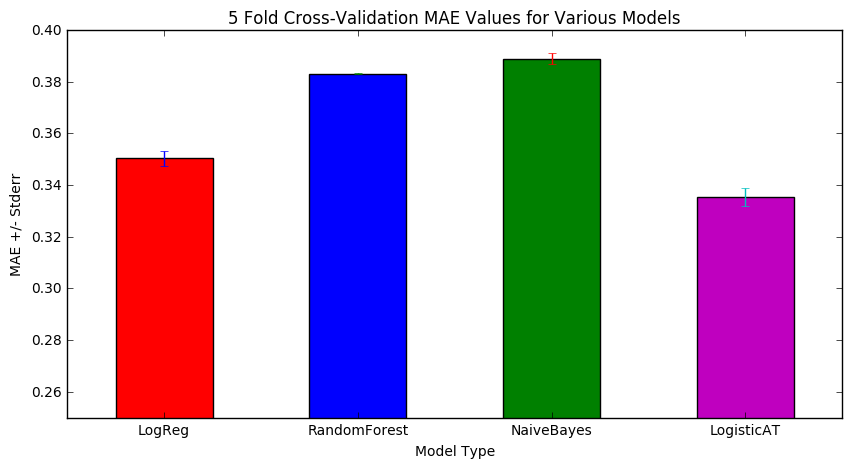

In [125]:
#plot cross validation results for Various Models
fig, ax = plt.subplots()

x_labels = ['LogReg','RandomForest','NaiveBayes','LogisticAT']

ax.bar(1,cross_avgs[0], 0.5, color='r', yerr=cross_stds[0],align='center')
ax.bar(2,cross_avgs[1], 0.5, color='b', yerr=cross_stds[1],align='center')
ax.bar(3,cross_avgs[2], 0.5, color='g', yerr=cross_stds[2],align='center')
ax.bar(4,cross_avgs[3], 0.5, color='m', yerr=cross_stds[3],align='center')

plt.xticks([1,2,3,4],x_labels)
plt.xlabel("Model Type")
plt.ylabel("MAE +/- Stderr")
plt.title("5 Fold Cross-Validation MAE Values for Various Models")
plt.ylim(0.25,0.4)
plt.show()

In [41]:
#get MAE for prediction on test set
print(mean_absolute_error(Y_test,log_AT.predict(X_test_data)))

0.341966280723


In [42]:
stat_data = X_train.drop('cleantext',axis=1)
columns = stat_data.columns.values
f_stats, pvals = f_classif(stat_data,Y_train)

sorted_array = pd.DataFrame(sorted(zip(f_stats,pvals,columns),reverse=True)).dropna().reset_index(drop=True)

In [43]:
print(sorted_array)

             0              1                      2
0   423.757105  8.259795e-183                 No Fee
1   206.996133   3.732139e-90            Reduced Fee
2   153.270144   4.935746e-67                Doorman
3   117.771692   1.011015e-51    Laundry in Building
4    71.793929   7.533514e-32           Dogs Allowed
5    70.239528   3.545189e-31              Furnished
6    56.897538   2.115172e-25           Cats Allowed
7    54.022341   3.719810e-24         Fitness Center
8    50.475429   1.278936e-22  Private Outdoor Space
9    41.616429   8.816319e-19     Short Term Allowed
10   30.608431   5.214932e-14        Laundry In Unit
11   28.815096   3.125436e-13               bedrooms
12   25.895693   5.768092e-12               Elevator
13   24.824043   1.682074e-11              Exclusive
14   19.489508   3.467373e-09   Common Outdoor Space
15   27.768429   8.888331e-13            photo_count
16   20.657412   1.079699e-09                   week
17   18.825879   6.728689e-09          Parking